In [1]:
import sys
from pathlib import Path

path_root = Path( '/project_ghent/HADSP/reservoirpy/')
sys.path.append(str(path_root))
path_root = Path( '/project_ghent/HADSP/hadsp/')
sys.path.append(str(path_root))

In [2]:
import numpy as np
from tqdm import tqdm

import reservoirpy
reservoirpy.verbosity(0)

from matplotlib import pyplot as plt
from seaborn import heatmap, color_palette

In [3]:
# Utility functions
from reservoir.utility import show_matrice

# SEED
SEED = 49387

# Reservoir functions

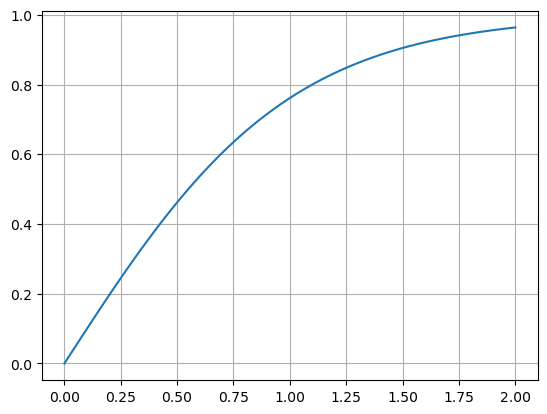

In [4]:
from reservoir.reservoir import update_reservoir, ridge_regression, train, run
from reservoir.activation_functions import tanh, heaviside, sigmoid

# the activation function choosen for the rest of the experiment
# activation_function = lambda x : sigmoid(2*(x-0.5))
activation_function = lambda x : tanh(x)

plt.plot(np.linspace(0, 2, 100), activation_function(np.linspace(0, 2, 100)))
plt.grid()

# Datasets

Lots of different on availabale : https://towardsdatascience.com/a-data-lakes-worth-of-audio-datasets-b45b88cd4ad

Classification: 
https://arxiv.org/abs/1803.07870

https://github.com/FilippoMB/Time-series-classification-and-clustering-with-Reservoir-Computing

Multivariate:
https://www.timeseriesclassification.com/dataset.php

## Free Spoken Digits Dataset

In [7]:
from datasets.load_datasets import load_FSDD_dataset

data_dir = 'datasets/fsdd/free-spoken-digit-dataset-master/recordings'  # Path to the extracted dataset
sampling_rate, X_train, X_test, Y_train, Y_test = load_FSDD_dataset(data_dir, seed=SEED, visualize=False)
# Check the shapes of the datasets
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

Number of audio files: 3000


  0%|          | 0/3000 [00:00<?, ?it/s]2023-07-31 11:01:28.618694: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3000]
	 [[{{node Placeholder/_0}}]]
100%|██████████| 3000/3000 [00:00<00:00, 3795.03it/s]


Mean sampling rate: 8000.0
X_train shape: (1500,)
Y_train shape: (1500, 10)
X_test shape: (1500,)
Y_test shape: (1500, 10)


# New inputs creation with band filters

Spectrograms_vs_Cochleagrams : 
* https://www.researchgate.net/publication/340510607_Speech_recognition_using_very_deep_neural_networks_Spectrograms_vs_Cochleagrams

## Pretrain dataset

In [8]:
#take a long time (15min with half the samples, instant with 20 which is enought for pretraining)
X_pretrain = np.concatenate(X_train[:20], axis=0)
print(X_pretrain.shape)

(83943, 1)


## Spectral density and peak selection

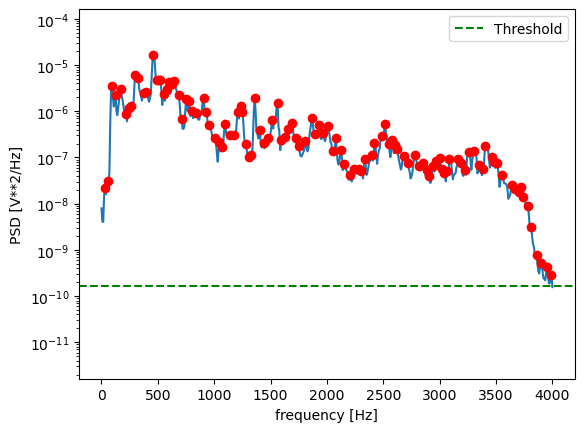

Filtered peak frequencies:  [  31.25     54.6875   93.75    125.      171.875   218.75    242.1875
  265.625   296.875   320.3125  375.      398.4375  460.9375  492.1875
  507.8125  523.4375  554.6875  578.125   601.5625  625.      640.625
  687.5     710.9375  750.      773.4375  804.6875  835.9375  906.25
  929.6875  953.125  1007.8125 1046.875  1070.3125 1093.75   1140.625
 1171.875  1210.9375 1234.375  1250.     1281.25   1312.5    1328.125
 1359.375  1406.25   1437.5    1476.5625 1515.625  1562.5    1593.75
 1625.     1656.25   1687.5    1726.5625 1750.     1804.6875 1867.1875
 1898.4375 1929.6875 1968.75   2007.8125 2054.6875 2078.125  2125.
 2148.4375 2203.125  2242.1875 2281.25   2304.6875 2335.9375 2398.4375
 2421.875  2484.375  2515.625  2546.875  2578.125  2601.5625 2625.
 2679.6875 2718.75   2781.25   2820.3125 2851.5625 2890.625  2906.25
 2945.3125 2968.75   3000.     3023.4375 3039.0625 3062.5    3085.9375
 3164.0625 3187.5    3226.5625 3257.8125 3304.6875 3351.5625 3382.

In [9]:
from datasets.multivariate_generation import generate_multivariate_dataset, extract_peak_frequencies

filtered_peak_freqs = extract_peak_frequencies(X_pretrain.flatten(), sampling_rate, threshold=1e-5, nperseg=1024, visualize=True)

## Applying normal band pass filter on data

In [10]:
X_pretrain_band, X_train_band, X_test_band = generate_multivariate_dataset(filtered_peak_freqs, X_pretrain, X_train, X_test, sampling_rate, nb_jobs=-1, visualize=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 720 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 1170 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   15.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 660 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 1360 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   11.1s finished


## Standardizing the amplitudes

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

# pretrain
filtered_data = scaler.fit_transform(X_pretrain_band)

In [12]:
# train
X_train_band = [np.array([scaler.fit_transform(time_serie.reshape(-1, 1)).flatten() for time_serie in x]) for x in X_train_band]

In [13]:
# test
X_test_band = [np.array([scaler.fit_transform(time_serie.reshape(-1, 1)).flatten() for time_serie in x]) for x in X_test_band]

In [14]:
X_train_band[0].shape

(114, 4611)

## preprocessing to have the right shape

In [15]:
import math 

# We want the size of the reservoir to be at least 200
K = math.ceil(200 / filtered_peak_freqs.shape[0])
n = filtered_peak_freqs.shape[0] * K
n

228

In [16]:
from connexion_generation.bounded_adsp import TwoDimArrayWrapper

frequency_bands = np.repeat(filtered_data, K, axis=0)

frequency_bands = TwoDimArrayWrapper(frequency_bands)

In [17]:
# We want the size of the reservoir to be at least 200
caca = []
caca_test = []
for i in range(len(X_train_band)):
    #caca.append(np.repeat(X_train[i], K, axis=1))
    caca.append(np.repeat(X_train_band[i], K, axis=0).T) # axis still depend of X_train shape
for i in range(len(X_test_band)):
    #caca_test.append(np.repeat(X_test[i], K, axis=1))
    caca_test.append(np.repeat(X_test_band[i], K, axis=0).T)


# Create a list to store the arrays

pipi = []
pipi_test = []

for i in range(len(X_train)):
    pipi.append(np.repeat(X_train[i], n, axis=1))
    #pipi.append(np.repeat(X_train[i], n, axis=0).T) # axis still depend of X_train shape
    
for i in range(len(X_test)):
    pipi_test.append(np.repeat(X_test[i], n, axis=1))
    #pipi_test.append(np.repeat(X_test[i], n, axis=0).T)
    
pipi[0].shape

(4611, 228)

## Plot  pretrain dataset

In [18]:
# Min window size to get all the dynamics ? 
min_window_size = sampling_rate/filtered_peak_freqs[-1]

min_window_size

2.003913894324853

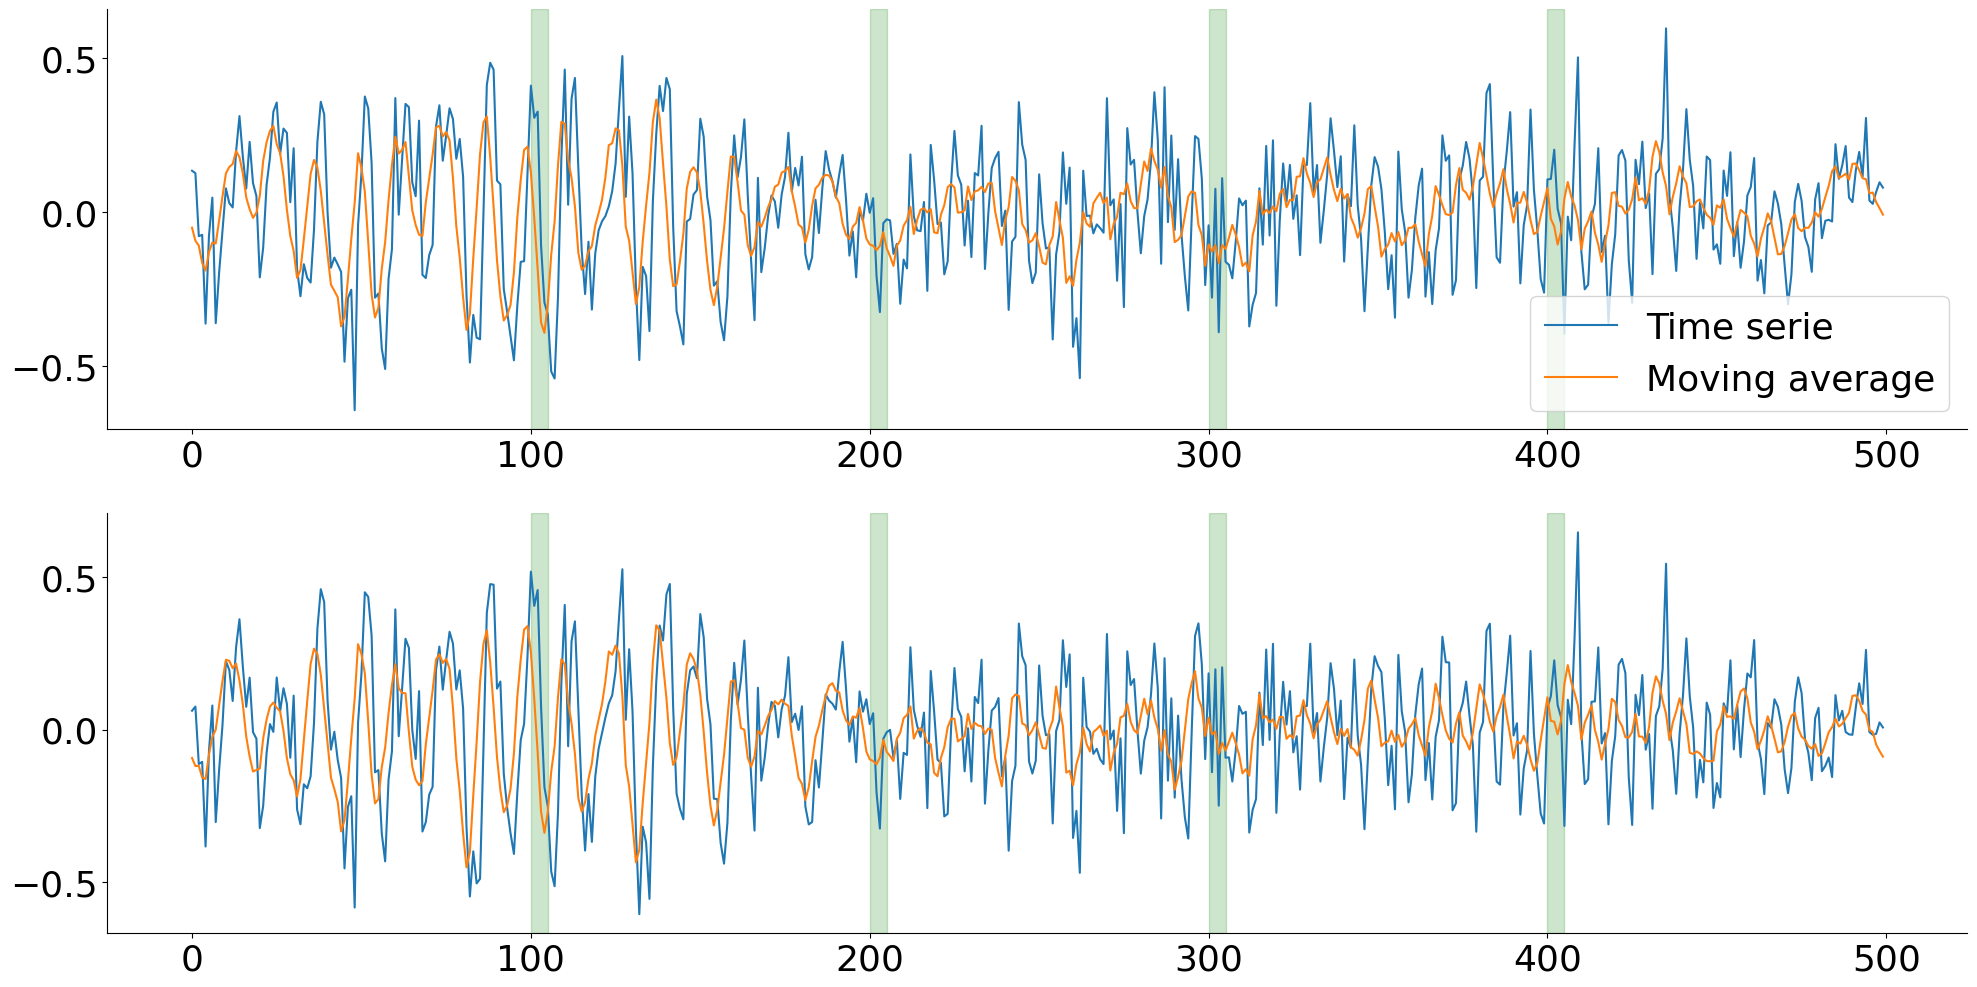

In [19]:
#Compute the moving average 
window_size = 5
weights = np.repeat(1.0, window_size)/window_size
ma = np.array([np.convolve(d, weights, 'valid') for d in (filtered_data)])

#CPlot the two for different frequencies
NB_1 = 3
fig, ax = plt.subplots(2, 1, figsize=(24,12))
ax[0].plot(range(500), filtered_data[NB_1, 1000:1500], label='Time serie')
ax[0].plot(range(500), ma[NB_1, 1000:1500], label='Moving average')
NB_2 = 10
ax[0].legend(fontsize=26)
ax[1].plot(range(500), filtered_data[NB_2, 1000:1500], label='Time serie')
ax[1].plot(range(500), ma[NB_2, 1000:1500], label='Moving average')

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[0].tick_params(axis='both', labelsize=26)
ax[1].tick_params(axis='both', labelsize=26)


# draw vertical lines to represent the window for some points
for x in range(100, 500, 100):
    ax[0].axvspan(x, x+window_size, color='g', alpha=0.2)
for x in range(100, 500, 100):
    ax[1].axvspan(x, x+window_size, color='g', alpha=0.2)

plt.show()

# Function definition

In [20]:
from reservoir.reservoir import init_matrices
from connexion_generation.bounded_adsp import run_HADSP_algorithm
from scipy import sparse

def initialise_and_train(input_scaling, n, bias_scaling, leaky_rate, activation_function, seed, 
                         input_data, increment, value, target_rate, growth_parameter, visualize=False):    
    Win, W, bias = init_matrices(n, 1, 0, seed=seed)
    bias *= bias_scaling
    Win *= input_scaling
    
    W = run_HADSP_algorithm(W, Win, bias, leaky_rate, activation_function, input_data, increment, value, target_rate, growth_parameter, visualize=visualize)

    connectivity =  W.count_nonzero() / (W.shape[0] * W.shape[1])
    eigen = sparse.linalg.eigs(W, k=1, which="LM", maxiter=W.shape[0] * 20, tol=0.1, return_eigenvectors=False)
    sr = max(abs(eigen))
    
    return Win, W, bias, connectivity, sr


In [21]:
from performances.esn_model_evaluation import train_and_predict_model, compute_score


# Exploration

## Gridsearch

In [23]:
import signal

class TimeoutException(Exception):   # Custom exception class
    pass

def timeout_handler(signum, frame):   # Custom signal handler
    raise TimeoutException

# Set the signal handler and a 5-minute alarm
signal.signal(signal.SIGALRM, timeout_handler)

NORMAL_SR = [0.9, 1, 1.1, 1.2]
scores_hadsp_multi = {sr: [] for sr in NORMAL_SR}
scores_random_multi = {sr: [] for sr in NORMAL_SR}
scores_hadsp_uni = {sr: [] for sr in NORMAL_SR}
scores_random_uni = {sr: [] for sr in NORMAL_SR}

INCREMENT = 5
VALUE = 0.05
target_rate = 0.8
growth_parameter = 0.15

bias_scaling = 1
leaky_rate = 1
input_scaling = 0.15
ridge_coef = 1e-7
N_JOBS = -1

for SEED in [234234, 3413123, 43879]: 
    # HADSP + multi
    try:
        # Start a timer for 5 minutes
        signal.alarm(300)
        Win_hasp_band, W_hasp_band, bias_hasp_band, connectivity_band, sr_adsp = initialise_and_train(input_scaling, n, bias_scaling, leaky_rate, activation_function, SEED, frequency_bands, INCREMENT, VALUE, target_rate, growth_parameter)
    except TimeoutException:
        print(f"SEED {SEED} exceeded the time limit: {e}")
        continue
    else:
        signal.alarm(0)   # Resets the alarm if successful
    
    # 3rd (random + multi)
    Win_3, W_3, bias_3 =  init_matrices(n, 1, connectivity_band)
    bias_3= bias_3*bias_scaling
    Win_3= Win_3*input_scaling
    
    eigen_3 = sparse.linalg.eigs(W_3, k=1, which="LM", maxiter=W_3.shape[0] * 20, tol=0.1, return_eigenvectors=False)
    sr_3 = max(abs(eigen_3))
    
    # HADSP + uni
    Win_hadsp_uni, W_hadsp_uni, bias_hadsp_uni, connectivity_hadsp_uni, sr_hadsp_uni = initialise_and_train(input_scaling, n, bias_scaling, leaky_rate, activation_function, SEED, X_pretrain.flatten(), INCREMENT, VALUE, target_rate, growth_parameter)

    # random + uni
    Win_normal, W_normal, bias_normal =  init_matrices(n, 1, connectivity_hadsp_uni)
    bias_normal= bias_normal*bias_scaling
    Win_normal= Win_normal*input_scaling   

    eigen_normal = sparse.linalg.eigs(W_normal, k=1, which="LM", maxiter=W_normal.shape[0] * 20, tol=0.1, return_eigenvectors=False)
    sr_normal = max(abs(eigen_normal))


    for normal_sr in NORMAL_SR:
    # Spectral radius normalisation
        W_hasp_band = W_hasp_band/sr_adsp*normal_sr
        W_3 = W_3/sr_3*normal_sr
        W_hadsp_uni = W_hadsp_uni/sr_hadsp_uni*normal_sr    
        W_normal = W_normal/sr_normal*normal_sr
        
        #  HADSP + multivariate dataset
        Y_pred_hasp_band = train_and_predict_model(W_hasp_band, Win_hasp_band, bias_hasp_band, activation_function, ridge_coef, caca, caca_test, Y_train, Y_test, n_jobs=N_JOBS)
        # random + multivariate dataset
        Y_pred_3 = train_and_predict_model(W_3, Win_3, bias_3, activation_function, ridge_coef, caca, caca_test, Y_train, Y_test, n_jobs=N_JOBS)
        
        # HADSP + univariate dataset
        Y_pred_hadsp_uni = train_and_predict_model(W_hadsp_uni, Win_hadsp_uni, bias_hadsp_uni, activation_function, ridge_coef, pipi, pipi_test, Y_train, Y_test, n_jobs=N_JOBS)
        # random + multivariate dataset
        Y_pred_normal = train_and_predict_model(W_normal, Win_normal, bias_normal, activation_function, ridge_coef, pipi, pipi_test, Y_train, Y_test, n_jobs=N_JOBS)
    
        
        scores_hadsp_multi[normal_sr].append(compute_score(Y_pred_hasp_band, Y_test, "HADSP multi"))
        scores_random_multi[normal_sr].append(compute_score(Y_pred_3, Y_test, "random multi"))
        scores_hadsp_uni[normal_sr].append(compute_score(Y_pred_hadsp_uni, Y_test, "HADSP uni"))
        scores_random_uni[normal_sr].append(compute_score(Y_pred_normal, Y_test, "random uni"))


Accuracy for HADSP multi: 16.400 %
Accuracy for random multi: 15.733 %
Accuracy for HADSP uni: 9.533 %
Accuracy for random uni: 8.667 %
Accuracy for HADSP multi: 16.533 %
Accuracy for random multi: 15.733 %
Accuracy for HADSP uni: 9.733 %
Accuracy for random uni: 8.667 %
Accuracy for HADSP multi: 16.000 %
Accuracy for random multi: 15.933 %
Accuracy for HADSP uni: 9.933 %
Accuracy for random uni: 8.400 %
Accuracy for HADSP multi: 15.733 %
Accuracy for random multi: 16.467 %
Accuracy for HADSP uni: 9.667 %
Accuracy for random uni: 9.333 %
Accuracy for HADSP multi: 16.133 %
Accuracy for random multi: 15.733 %
Accuracy for HADSP uni: 9.667 %
Accuracy for random uni: 8.667 %
Accuracy for HADSP multi: 16.333 %
Accuracy for random multi: 15.733 %
Accuracy for HADSP uni: 9.800 %
Accuracy for random uni: 8.667 %
Accuracy for HADSP multi: 17.067 %
Accuracy for random multi: 15.933 %
Accuracy for HADSP uni: 10.000 %
Accuracy for random uni: 8.400 %
Accuracy for HADSP multi: 16.667 %
Accuracy for

In [24]:
# For each normal_sr, compute the mean and standard deviation of the scores
for normal_sr in NORMAL_SR:
    print(f"normal_sr : {normal_sr}")
    mean_hadsp_multi = np.mean(scores_hadsp_multi[normal_sr])
    std_hadsp_multi = np.std(scores_hadsp_multi[normal_sr])
    print(f'Mean and Std for HADSP multi: {mean_hadsp_multi}, {std_hadsp_multi}')

    mean_random_multi = np.mean(scores_random_multi[normal_sr])
    std_random_multi = np.std(scores_random_multi[normal_sr])
    print(f'Mean and Std for random multi: {mean_random_multi}, {std_random_multi}')

    mean_hadsp_uni = np.mean(scores_hadsp_uni[normal_sr])
    std_hadsp_uni = np.std(scores_hadsp_uni[normal_sr])
    print(f'Mean and Std for HADSP uni: {mean_hadsp_uni}, {std_hadsp_uni}')

    mean_random_uni = np.mean(scores_random_uni[normal_sr])
    std_random_uni = np.std(scores_random_uni[normal_sr])
    print(f'Mean and Std for random uni: {mean_random_uni}, {std_random_uni}')


normal_sr : 0.9
Mean and Std for HADSP multi: 0.16222222222222224, 0.0012570787221094233
Mean and Std for random multi: 0.15733333333333333, 0.0
Mean and Std for HADSP uni: 0.0971111111111111, 0.0016629588385661924
Mean and Std for random uni: 0.08666666666666667, 0.0
normal_sr : 1
Mean and Std for HADSP multi: 0.1651111111111111, 0.001369869778437548
Mean and Std for random multi: 0.15733333333333333, 0.0
Mean and Std for HADSP uni: 0.09799999999999999, 0.0005443310539518197
Mean and Std for random uni: 0.08666666666666667, 0.0
normal_sr : 1.1
Mean and Std for HADSP multi: 0.1648888888888889, 0.004399775527382958
Mean and Std for random multi: 0.15933333333333333, 0.0
Mean and Std for HADSP uni: 0.09888888888888887, 0.0011331154474650672
Mean and Std for random uni: 0.084, 0.0
normal_sr : 1.2
Mean and Std for HADSP multi: 0.16244444444444442, 0.003861810488218393
Mean and Std for random multi: 0.16466666666666666, 0.0
Mean and Std for HADSP uni: 0.09777777777777778, 0.0008314794192830

In [25]:
# Open the file in write mode
with open('output.txt', 'w') as f:
    # Write the configuration to the file
    f.write(f"Configuration:\nINCREMENT = {INCREMENT}\nVALUE = {VALUE}\ntarget_rate = {target_rate}\n"
            f"growth_parameter = {growth_parameter}\nbias_scaling = {bias_scaling}\nleaky_rate = {leaky_rate}\n"
            f"input_scaling = {input_scaling}\nridge_coef = {ridge_coef}\nN_JOBS = {N_JOBS}\n\n")

    # For each normal_sr, compute the mean and standard deviation of the scores
    for normal_sr in NORMAL_SR:
        f.write(f"normal_sr : {normal_sr}\n")

        mean_hadsp_multi = np.mean(scores_hadsp_multi[normal_sr])
        std_hadsp_multi = np.std(scores_hadsp_multi[normal_sr])
        f.write(f'Mean and Std for HADSP multi: {mean_hadsp_multi}, {std_hadsp_multi}\n')

        mean_random_multi = np.mean(scores_random_multi[normal_sr])
        std_random_multi = np.std(scores_random_multi[normal_sr])
        f.write(f'Mean and Std for random multi: {mean_random_multi}, {std_random_multi}\n')

        mean_hadsp_uni = np.mean(scores_hadsp_uni[normal_sr])
        std_hadsp_uni = np.std(scores_hadsp_uni[normal_sr])
        f.write(f'Mean and Std for HADSP uni: {mean_hadsp_uni}, {std_hadsp_uni}\n')

        mean_random_uni = np.mean(scores_random_uni[normal_sr])
        std_random_uni = np.std(scores_random_uni[normal_sr])
        f.write(f'Mean and Std for random uni: {mean_random_uni}, {std_random_uni}\n')

## Optimisation

In [ ]:
import optuna
import time


INCREMENT = 5
VALUE = 0.05
#target_rate = 0.7
#growth_parameter = 0.3

bias_scaling = 1
leaky_rate = 1
#input_scaling = 0.1
ridge_coef = 1e-7
N_JOBS = -1
NORMAL_SR = [0.9, 0.95, 1, 1.05, 1.1]
SEED = 89034

def objective(trial):
    target_rate = trial.suggest_float('target_rate', 0.6, 0.95, step=0.05)  
    growth_parameter = trial.suggest_float('growth_parameter', 0.1, 0.3, step=0.05)  
    input_scaling = trial.suggest_float('input_scaling', 0.1, 0.3, step=0.05)  
    scores_hadsp_multi = {sr: [] for sr in NORMAL_SR}
    scores_random_multi = {sr: [] for sr in NORMAL_SR}
    mean_difference=0


    # HADSP + multi
    for SEED in [234234, 43894, 479389]: 
        # HADSP + multi
        try:
            # Start a timer for 2.5 minutes
            signal.alarm(150)
            Win_hasp_band, W_hasp_band, bias_hasp_band, connectivity_band, sr_adsp = initialise_and_train(input_scaling, n, bias_scaling, leaky_rate, activation_function, SEED, frequency_bands, INCREMENT, VALUE, target_rate, growth_parameter)
        except TimeoutException:
            print(f"SEED {SEED} exceeded the time limit")
            #continue #when multiple SEED values
            return float('inf') # when only one SEED value
        else:
            signal.alarm(0)   # Resets the alarm if successful
        
        # 3rd (random + multi)
        Win_3, W_3, bias_3 =  init_matrices(n, 1, connectivity_band)
        bias_3= bias_3*bias_scaling
        Win_3= Win_3*input_scaling
        
        eigen_3 = sparse.linalg.eigs(W_3, k=1, which="LM", maxiter=W_3.shape[0] * 20, tol=0.1, return_eigenvectors=False)
        sr_3 = max(abs(eigen_3))
    
        for normal_sr in NORMAL_SR:
            # Spectral radius normalisation
            W_hasp_band = W_hasp_band/sr_adsp*normal_sr
            W_3 = W_3/sr_3*normal_sr
    
            #  HADSP + multivariate dataset
            Y_pred_hasp_band = train_and_predict_model(W_hasp_band, Win_hasp_band, bias_hasp_band, activation_function, ridge_coef, caca, caca_test, Y_train, Y_test, n_jobs=N_JOBS)
            # random + multivariate dataset
            Y_pred_3 = train_and_predict_model(W_3, Win_3, bias_3, activation_function, ridge_coef, caca, caca_test, Y_train, Y_test, n_jobs=N_JOBS)
            scores_hadsp_multi[normal_sr].append(compute_score(Y_pred_hasp_band, Y_test, "HADSP multi"))
            scores_random_multi[normal_sr].append(compute_score(Y_pred_3, Y_test, "random multi"))
    
            mean_difference += np.mean(scores_hadsp_multi[normal_sr]) - np.mean(scores_random_multi[normal_sr])
    # We return the negative of the difference of meanscores 
    # since Optuna tries to minimize the objective 
    # and we want that difference to be maximize
    return -mean_difference

study = optuna.create_study()
study.optimize(objective, n_trials=20)

# Best trial
trial = study.best_trial

print('Best target_rate: {}'.format(trial.params['target_rate']))
print('Best growth_parameter: {}'.format(trial.params['growth_parameter']))
print('Best input_scaling: {}'.format(trial.params['input_scaling']))
print('Best score: {}'.format(-trial.value))

# Individual networks

In [ ]:
import optuna
import time


INCREMENT = 5
VALUE = 0.05
#target_rate = 0.7
#growth_parameter = 0.3

bias_scaling = 1
leaky_rate = 1
#input_scaling = 0.1
ridge_coef = 1e-7
N_JOBS = -1

def objective(trial):
    normal_sr = trial.suggest_float('normal_sr', 0.8, 1.2, step=0.05)  
    target_rate = trial.suggest_float('target_rate', 0.6, 1, step=0.1)  
    growth_parameter = trial.suggest_float('growth_parameter', 0.1, 0.3, step=0.1)  
    input_scaling = trial.suggest_float('input_scaling', 0.1, 0.3, step=0.05)  
    scores_hadsp_multi = []


    for SEED in [234234, 43894, 479389]: 
        # HADSP + multi
        try:
            # Start a timer for 2.5 minutes
            signal.alarm(150)
            Win_hasp_band, W_hasp_band, bias_hasp_band, connectivity_band, sr_adsp = initialise_and_train(input_scaling, n, bias_scaling, leaky_rate, activation_function, SEED, frequency_bands, INCREMENT, VALUE, target_rate, growth_parameter)
        except TimeoutException:
            print(f"SEED {SEED} exceeded the time limit")
            return float('inf') # we stop this one as it's probably going to be the same result for all of them
        else:
            signal.alarm(0)   # Resets the alarm if successful

        # Spectral radius normalisation
        W_hasp_band = W_hasp_band/sr_adsp*normal_sr

        #  HADSP + multivariate dataset
        Y_pred_hasp_band = train_and_predict_model(W_hasp_band, Win_hasp_band, bias_hasp_band, activation_function, ridge_coef, caca, caca_test, Y_train, Y_test, n_jobs=N_JOBS)

        scores_hadsp_multi.append(compute_score(Y_pred_hasp_band, Y_test, "HADSP multi"))

    # We return the negative of the difference of meanscores 
    # since Optuna tries to minimize the objective 
    # and we want that difference to be maximize
    return -np.mean(scores_hadsp_multi)

study = optuna.create_study()
study.optimize(objective, n_trials=30)

# Best trial
trial = study.best_trial

print('Best normal_sr: {}'.format(trial.params['normal_sr']))
print('Best target_rate: {}'.format(trial.params['target_rate']))
print('Best growth_parameter: {}'.format(trial.params['growth_parameter']))
print('Best input_scaling: {}'.format(trial.params['input_scaling']))
print('Best score: {}'.format(-trial.value))

[I 2023-07-31 13:32:32,280] A new study created in memory with name: no-name-7b52d6bf-fc17-478d-9964-0770f89453ca


Accuracy for HADSP multi: 15.800 %
Accuracy for HADSP multi: 15.733 %


[I 2023-07-31 13:36:22,843] Trial 0 finished with value: -0.15711111111111112 and parameters: {'normal_sr': 1.05, 'target_rate': 0.9, 'growth_parameter': 0.1, 'input_scaling': 0.3}. Best is trial 0 with value: -0.15711111111111112.


Accuracy for HADSP multi: 15.600 %
Accuracy for HADSP multi: 15.800 %
Accuracy for HADSP multi: 15.533 %


[I 2023-07-31 13:39:49,905] Trial 1 finished with value: -0.15688888888888888 and parameters: {'normal_sr': 1.1500000000000001, 'target_rate': 0.8, 'growth_parameter': 0.3, 'input_scaling': 0.3}. Best is trial 0 with value: -0.15711111111111112.


Accuracy for HADSP multi: 15.733 %
Accuracy for HADSP multi: 16.467 %
Accuracy for HADSP multi: 16.267 %


[I 2023-07-31 13:43:13,828] Trial 2 finished with value: -0.1628888888888889 and parameters: {'normal_sr': 1.1, 'target_rate': 0.8, 'growth_parameter': 0.3, 'input_scaling': 0.2}. Best is trial 2 with value: -0.1628888888888889.


Accuracy for HADSP multi: 16.133 %


[I 2023-07-31 13:45:43,851] Trial 3 finished with value: inf and parameters: {'normal_sr': 1.2, 'target_rate': 0.6, 'growth_parameter': 0.3, 'input_scaling': 0.3}. Best is trial 2 with value: -0.1628888888888889.


SEED 234234 exceeded the time limit


[I 2023-07-31 13:48:13,877] Trial 4 finished with value: inf and parameters: {'normal_sr': 1.05, 'target_rate': 0.7, 'growth_parameter': 0.3, 'input_scaling': 0.3}. Best is trial 2 with value: -0.1628888888888889.


SEED 234234 exceeded the time limit


[I 2023-07-31 13:50:43,903] Trial 5 finished with value: inf and parameters: {'normal_sr': 0.8500000000000001, 'target_rate': 0.7, 'growth_parameter': 0.1, 'input_scaling': 0.15000000000000002}. Best is trial 2 with value: -0.1628888888888889.


SEED 234234 exceeded the time limit
Accuracy for HADSP multi: 15.867 %
Accuracy for HADSP multi: 16.200 %


[I 2023-07-31 13:54:33,371] Trial 6 finished with value: -0.16 and parameters: {'normal_sr': 1.1500000000000001, 'target_rate': 0.9, 'growth_parameter': 0.2, 'input_scaling': 0.25}. Best is trial 2 with value: -0.1628888888888889.


Accuracy for HADSP multi: 15.933 %


[I 2023-07-31 13:57:03,400] Trial 7 finished with value: inf and parameters: {'normal_sr': 1.1500000000000001, 'target_rate': 0.6, 'growth_parameter': 0.3, 'input_scaling': 0.2}. Best is trial 2 with value: -0.1628888888888889.


SEED 234234 exceeded the time limit
Accuracy for HADSP multi: 15.467 %
Accuracy for HADSP multi: 15.400 %


[I 2023-07-31 14:00:28,783] Trial 8 finished with value: -0.15577777777777777 and parameters: {'normal_sr': 0.9500000000000001, 'target_rate': 0.9, 'growth_parameter': 0.2, 'input_scaling': 0.2}. Best is trial 2 with value: -0.1628888888888889.


Accuracy for HADSP multi: 15.867 %
Accuracy for HADSP multi: 15.733 %
Accuracy for HADSP multi: 15.467 %


[I 2023-07-31 14:03:56,283] Trial 9 finished with value: -0.15644444444444444 and parameters: {'normal_sr': 1.2, 'target_rate': 0.9, 'growth_parameter': 0.1, 'input_scaling': 0.2}. Best is trial 2 with value: -0.1628888888888889.


Accuracy for HADSP multi: 15.733 %
Accuracy for HADSP multi: 16.400 %
Accuracy for HADSP multi: 16.400 %


[I 2023-07-31 14:07:22,675] Trial 10 finished with value: -0.164 and parameters: {'normal_sr': 0.8, 'target_rate': 1.0, 'growth_parameter': 0.2, 'input_scaling': 0.1}. Best is trial 10 with value: -0.164.


Accuracy for HADSP multi: 16.400 %
Accuracy for HADSP multi: 16.267 %
Accuracy for HADSP multi: 15.867 %


[I 2023-07-31 14:10:49,083] Trial 11 finished with value: -0.16244444444444447 and parameters: {'normal_sr': 0.8, 'target_rate': 1.0, 'growth_parameter': 0.2, 'input_scaling': 0.1}. Best is trial 10 with value: -0.164.


Accuracy for HADSP multi: 16.600 %
Accuracy for HADSP multi: 15.667 %
Accuracy for HADSP multi: 15.800 %


[I 2023-07-31 14:14:15,175] Trial 12 finished with value: -0.156 and parameters: {'normal_sr': 0.9500000000000001, 'target_rate': 1.0, 'growth_parameter': 0.2, 'input_scaling': 0.1}. Best is trial 10 with value: -0.164.


Accuracy for HADSP multi: 15.333 %
Accuracy for HADSP multi: 16.867 %
Accuracy for HADSP multi: 16.600 %


[I 2023-07-31 14:17:37,361] Trial 13 finished with value: -0.1668888888888889 and parameters: {'normal_sr': 0.8500000000000001, 'target_rate': 0.8, 'growth_parameter': 0.3, 'input_scaling': 0.15000000000000002}. Best is trial 13 with value: -0.1668888888888889.


Accuracy for HADSP multi: 16.600 %
Accuracy for HADSP multi: 16.067 %
Accuracy for HADSP multi: 15.800 %


[I 2023-07-31 14:21:00,920] Trial 14 finished with value: -0.16066666666666665 and parameters: {'normal_sr': 0.8500000000000001, 'target_rate': 0.7, 'growth_parameter': 0.2, 'input_scaling': 0.15000000000000002}. Best is trial 13 with value: -0.1668888888888889.


Accuracy for HADSP multi: 16.333 %
Accuracy for HADSP multi: 16.200 %
Accuracy for HADSP multi: 16.667 %


[I 2023-07-31 14:24:26,089] Trial 15 finished with value: -0.16266666666666665 and parameters: {'normal_sr': 0.8, 'target_rate': 1.0, 'growth_parameter': 0.3, 'input_scaling': 0.15000000000000002}. Best is trial 13 with value: -0.1668888888888889.


Accuracy for HADSP multi: 15.933 %
Accuracy for HADSP multi: 15.800 %
Accuracy for HADSP multi: 15.867 %


[I 2023-07-31 14:27:51,172] Trial 16 finished with value: -0.16 and parameters: {'normal_sr': 0.9, 'target_rate': 0.8, 'growth_parameter': 0.1, 'input_scaling': 0.1}. Best is trial 13 with value: -0.1668888888888889.


Accuracy for HADSP multi: 16.333 %
Accuracy for HADSP multi: 16.600 %
Accuracy for HADSP multi: 16.267 %


[I 2023-07-31 14:31:16,541] Trial 17 finished with value: -0.164 and parameters: {'normal_sr': 0.9, 'target_rate': 0.9, 'growth_parameter': 0.2, 'input_scaling': 0.15000000000000002}. Best is trial 13 with value: -0.1668888888888889.


Accuracy for HADSP multi: 16.333 %
Accuracy for HADSP multi: 16.133 %
Accuracy for HADSP multi: 16.600 %


[I 2023-07-31 14:34:36,502] Trial 18 finished with value: -0.1648888888888889 and parameters: {'normal_sr': 0.8500000000000001, 'target_rate': 0.7, 'growth_parameter': 0.3, 'input_scaling': 0.1}. Best is trial 13 with value: -0.1668888888888889.


Accuracy for HADSP multi: 16.733 %
Accuracy for HADSP multi: 16.600 %
Accuracy for HADSP multi: 16.267 %


[I 2023-07-31 14:37:58,129] Trial 19 finished with value: -0.16466666666666666 and parameters: {'normal_sr': 0.9500000000000001, 'target_rate': 0.7, 'growth_parameter': 0.3, 'input_scaling': 0.15000000000000002}. Best is trial 13 with value: -0.1668888888888889.


Accuracy for HADSP multi: 16.533 %
Accuracy for HADSP multi: 17.133 %
Accuracy for HADSP multi: 16.867 %


[I 2023-07-31 14:41:17,859] Trial 20 finished with value: -0.17088888888888887 and parameters: {'normal_sr': 0.8500000000000001, 'target_rate': 0.6, 'growth_parameter': 0.3, 'input_scaling': 0.1}. Best is trial 20 with value: -0.17088888888888887.


Accuracy for HADSP multi: 17.267 %
Accuracy for HADSP multi: 17.200 %
Accuracy for HADSP multi: 16.067 %


[I 2023-07-31 14:44:37,024] Trial 21 finished with value: -0.16777777777777778 and parameters: {'normal_sr': 0.8500000000000001, 'target_rate': 0.6, 'growth_parameter': 0.3, 'input_scaling': 0.1}. Best is trial 20 with value: -0.17088888888888887.


Accuracy for HADSP multi: 17.067 %
Accuracy for HADSP multi: 16.800 %
Accuracy for HADSP multi: 16.533 %


[I 2023-07-31 14:47:56,154] Trial 22 finished with value: -0.1677777777777778 and parameters: {'normal_sr': 0.9, 'target_rate': 0.6, 'growth_parameter': 0.3, 'input_scaling': 0.1}. Best is trial 20 with value: -0.17088888888888887.


Accuracy for HADSP multi: 17.000 %
Accuracy for HADSP multi: 16.867 %
Accuracy for HADSP multi: 16.400 %


[I 2023-07-31 14:51:15,542] Trial 23 finished with value: -0.166 and parameters: {'normal_sr': 0.9, 'target_rate': 0.6, 'growth_parameter': 0.3, 'input_scaling': 0.1}. Best is trial 20 with value: -0.17088888888888887.


Accuracy for HADSP multi: 16.533 %
Accuracy for HADSP multi: 16.800 %
Accuracy for HADSP multi: 17.067 %


[I 2023-07-31 14:54:34,493] Trial 24 finished with value: -0.16977777777777778 and parameters: {'normal_sr': 0.9, 'target_rate': 0.6, 'growth_parameter': 0.3, 'input_scaling': 0.1}. Best is trial 20 with value: -0.17088888888888887.


Accuracy for HADSP multi: 17.067 %


[I 2023-07-31 14:57:04,537] Trial 25 finished with value: inf and parameters: {'normal_sr': 1.0, 'target_rate': 0.6, 'growth_parameter': 0.3, 'input_scaling': 0.25}. Best is trial 20 with value: -0.17088888888888887.


SEED 234234 exceeded the time limit
Accuracy for HADSP multi: 16.467 %
Accuracy for HADSP multi: 16.600 %


[I 2023-07-31 15:00:23,541] Trial 26 finished with value: -0.16644444444444442 and parameters: {'normal_sr': 1.0, 'target_rate': 0.6, 'growth_parameter': 0.3, 'input_scaling': 0.1}. Best is trial 20 with value: -0.17088888888888887.


Accuracy for HADSP multi: 16.867 %
Accuracy for HADSP multi: 16.067 %
Accuracy for HADSP multi: 16.000 %


[I 2023-07-31 15:03:46,642] Trial 27 finished with value: -0.16044444444444445 and parameters: {'normal_sr': 0.9, 'target_rate': 0.6, 'growth_parameter': 0.3, 'input_scaling': 0.15000000000000002}. Best is trial 20 with value: -0.17088888888888887.


Accuracy for HADSP multi: 16.067 %


In [30]:
import optuna


bias_scaling = 1
leaky_rate = 1
ridge_coef = 1e-7
N_JOBS = -1

def objective(trial):
    normal_sr = trial.suggest_float('normal_sr', 0.8, 1.2, step=0.05)  
    connectivity = trial.suggest_float('connectivity', 0.3, 0.8, step=0.02)  
    input_scaling = trial.suggest_float('input_scaling', 0.1, 0.3, step=0.05)  
    scores_random_multi = []


    for SEED in [234234, 43894, 479389]: 
        
        # 3rd (random + multi)
        Win_3, W_3, bias_3 =  init_matrices(n, 1, connectivity)
        bias_3= bias_3*bias_scaling
        Win_3= Win_3*input_scaling
        
        eigen_3 = sparse.linalg.eigs(W_3, k=1, which="LM", maxiter=W_3.shape[0] * 20, tol=0.1, return_eigenvectors=False)
        sr_3 = max(abs(eigen_3))
        
        # Spectral radius normalisation
        W_3 = W_3/sr_3*normal_sr
        
        #  HADSP + multivariate dataset
        Y_pred_3 = train_and_predict_model(W_3, Win_3, bias_3, activation_function, ridge_coef, caca, caca_test, Y_train, Y_test, n_jobs=N_JOBS)
        scores_random_multi.append(compute_score(Y_pred_3, Y_test, "random multi"))
     
    # We return the negative of the difference of meanscores 
    # since Optuna tries to minimize the objective 
    # and we want that difference to be maximize
    return -np.mean(scores_random_multi)

study = optuna.create_study()
study.optimize(objective, n_trials=30)

# Best trial
trial = study.best_trial

print('Best normal_sr: {}'.format(trial.params['normal_sr']))
print('Best target_rate: {}'.format(trial.params['target_rate']))
print('Best growth_parameter: {}'.format(trial.params['growth_parameter']))
print('Best input_scaling: {}'.format(trial.params['input_scaling']))
print('Best score: {}'.format(-trial.value))

[I 2023-07-31 12:57:34,390] A new study created in memory with name: no-name-ad8821f7-b2b5-4453-9dda-9b3dacb20d19


Accuracy for random multi: 16.200 %


[W 2023-07-31 12:59:58,004] Trial 0 failed with parameters: {'normal_sr': 0.9500000000000001, 'connectivity': 0.74, 'input_scaling': 0.15000000000000002} because of the following error: TimeoutException().
Traceback (most recent call last):
  File "/project_ghent/HADSP/HADSP_env/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_88572/2375014024.py", line 30, in objective
    Y_pred_3 = train_and_predict_model(W_3, Win_3, bias_3, activation_function, ridge_coef, caca, caca_test, Y_train, Y_test, n_jobs=N_JOBS)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/project_ghent/HADSP/hadsp/performances/esn_model_evaluation.py", line 37, in train_and_predict_model
    Y_pred = Parallel(n_jobs=n_jobs)(delayed(predict)(x) for x in X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^

TimeoutException: 